In [ ]:
!pip install tabula-py
!pip install pdfplumber
!pip install jpype1

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabula import read_pdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/madhoolikacvss/CSE151A_Project.git


In [ ]:
!cd CSE151A_Project && git pull

In [ ]:
# CROP is Zooplankton data from 2000 to 2021
fdf = read_pdf("/content/CSE151A_Project/ZooDBCrop.pdf",pages = "all", lattice = True)
print("shape of fdf: ",len(fdf[0]))
for i in range(len(fdf)):
  print(len(fdf[i].columns))
  print(fdf[i].columns)

headers = ['Cruise', 'Ship', 'Date', 'Line', 'Station', 'Region', 'TowBegin', 'TowEnd', 'Latitude', 'Longitude', 'Abundance', 'Tows', 'Source']
cleaned_dfs = []
for df in fdf:
    df.columns = headers
    cleaned_dfs.append(df)
combined_df = pd.concat(cleaned_dfs, ignore_index=True)

In [ ]:
# CROP2 is Zooplankton data from 1980 to 1999
fdf2 = read_pdf("/content/CSE151A_Project/ZooDBCrop2.pdf",pages = "all", lattice = True)
print("shape of fdf: ",len(fdf[0]))
for i in range(len(fdf2)):
  print(len(fdf2[i].columns))
  print(fdf2[i].columns)

headers = ['Cruise', 'Ship', 'Date', 'Line', 'Station', 'Region', 'TowBegin', 'TowEnd', 'Latitude', 'Longitude', 'Abundance', 'Tows', 'Source']
cleaned_dfs2 = []
for df in fdf2:
    df.columns = headers
    cleaned_dfs2.append(df)
combined_df2 = pd.concat(cleaned_dfs2, ignore_index=True)

In [ ]:
dataset = pd.concat([combined_df, combined_df2], axis=0, ignore_index=True)
print("shape:",dataset.shape)

In [ ]:
# These columns all have N/A value. So we have to drop them.
dataset = dataset.drop(columns=['Tows','TowBegin', 'Ship', 'Source', 'Line',	'TowEnd', 'Longitude', 'Cruise', 'Station',	'Latitude'])
dataset = dataset.dropna()

In [ ]:
dataset

The data in the column Region is one of the two values 'SC' or 'CC'. It has no order so using One - Hot Encoding. We can use 1 for 'SC' and 0 for 'CC', but by doing this we are giving an order to these values where there is no true zero. That is why we are prefering One Hot Encoding as this data is nominal.

In [ ]:
# Binary Encoding
dataset = pd.get_dummies(dataset, columns=['Region'])
dataset['Region'] = dataset['Region_SC']
dataset.drop(['Region_CC', 'Region_SC'], axis=1, inplace=True)
dataset['Region'] = dataset['Region'].astype(int)
dataset

In [ ]:
# The Date column has "\r" in the date, which is irrelevant so we are cleaning it by replacing "\r" with an empty string.
dataset['Date'] = dataset['Date'].str.replace("\r", "", regex=False)
dataset['Year'] = dataset['Date'].str.extract(r'(\d{4})')
dataset

In [ ]:
dataset.info()
dataset

In [ ]:
# Converting the date into fractional year format so this can be used in the Abundance model
dataset['Date'] = pd.to_datetime(dataset['Date'])

dataset['Fractional_Year'] = (
    dataset['Date'].dt.year
    + (dataset['Date'].dt.dayofyear - 1)
    / dataset['Date'].dt.is_leap_year.apply(lambda x: 366 if x else 365)
)
dataset

In [ ]:
dataset['Abundance'] = dataset['Abundance'].str.replace(',', '', regex=False)
dataset['Abundance'] = pd.to_numeric(dataset['Abundance'], errors='coerce')

In [ ]:
dataset

In [ ]:
#Pairplot
sns.pairplot(dataset, vars=["Region", "Abundance"], hue="Year", palette="viridis")
# Color coded by Date, can change to other column to observe chnages from different perspectives
plt.suptitle("Pair Plot of ZOODBC", y=1)
plt.show()

In [ ]:
matrix = dataset.corr()
sns.heatmap(matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap of ZOODBC")
plt.show()

# Abundance Model
So our first dataset that contains columns 'Abundance' and 'Year' has only 62 rows where as our second dataset has 1374 rows. We want to use the columns/ features such as "Depth", "Salinity", "Temp", "d13C-DIC", "DIC", "ALK" from the second dataset to predict the 'Abundance'.

The problem we have now is that we have to map the 'Abundance' from 62 rows(62 different points of time) to the 1374 samples in the second dataset. For this we have to assign a value for each of these samples based on the year (calculated from date) and assign an 'Abundance' value to that sample.

So we have created a regression model that predicts the 'Abundance' given a 'Year' based on our first dataset and assign the predict values of 'Abundance' to the corresponding samples in the second dataset.

## Why a model instead of directly mapping the 'Abundance' from the first dataset?

While we can just map the 'Abundance' from the first dataset, for instance the value of 'Abundance' in the year 2000 is 30910.5 and we can assign 30910.5 as the Abundance to all the samples from the second dataset with year 2000, it is not the best solution we can have as we assign the same Abundance values to all the samples in the same year.

To solve this, we plan on further improving the model in Milestone 4 by predicting 'Abundance' based on the date so we can get different 'Abundance' values for different samples belonging to the same year. This can be done by using a fractional year format for the dates such as June 22, 1989 can be 1989.474 .

For this reason using a model to predict abundance as we can modify it later to adapt to dates instead of year.

##Milestone 3:Training abundance model - used to train our final model

PS: an improved version of this model is below, titled 'Milstone 4 ...'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
# Preparing the dataset
X = dataset[['Year']]  # Feature
y = dataset['Abundance']  # Target

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
abundanceModel = LinearRegression()
abundanceModel.fit(X_train, y_train)

# Making predictions
y_pred = abundanceModel.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
maep = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {maep}")

# Displaying the model coefficients
print(f"Intercept: {abundanceModel.intercept_}")
print(f"Coefficient: {abundanceModel.coef_[0]}")

#DATASET 2 (BATA+BERM+HAWI):

# What is Dataset 2
The dataset includes key columns: Station, Depth, Salinity. To facilitate analysis, we applied Min-Max normalization to the continuous variables: Depth, Salinity, Temp, d13C-DIC, DIC, and ALK, scaling them to a range of 0 to 1. This ensures all features can be compared fairly and prevents any single variable from skewing our results.



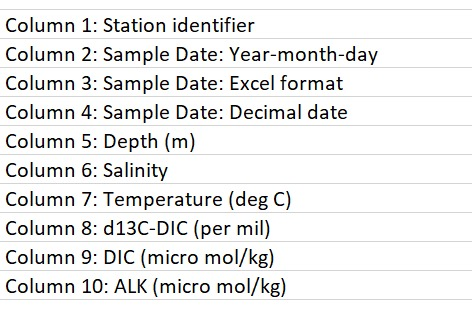

In [ ]:
!cd CSE151A_Project/ && ls


In [ ]:
!cd CSE151A_Project && git pull

In [ ]:
# BATS(1)
dataset2 = pd.read_csv('/content/CSE151A_Project/BATS.csv')
print(dataset2.columns)

# BERM
dataset3 = pd.read_csv('/content/CSE151A_Project/BERM.csv')
print(dataset3.columns)

# HAWI
dataset4 = pd.read_csv('/content/CSE151A_Project/HAWI.csv')
print(dataset4.columns)

combined_dataset = pd.concat([dataset2, dataset3, dataset4], ignore_index=True)

In [ ]:
combined_dataset = combined_dataset.drop(columns=['Station', '  Excel', ' Decimal' , 'Date'])


In [ ]:
combined_dataset


In [ ]:
combined_dataset = combined_dataset.rename(columns={
    " Sample": "Sample",
    " Depth": "Depth",
    "   Salinity": "Salinity",
    "    Temp": "Temp",
    " d13C-DIC": "d13C-DIC",
    "  DIC": "DIC",
    "   ALK": "ALK"
})


In [ ]:
combined_dataset.columns = combined_dataset.columns.str.strip()


In [ ]:
# Remove leading and trailing spaces from the 'Sample' column
combined_dataset['Sample'] = combined_dataset['Sample'].str.strip()
combined_dataset['Date'] = pd.to_datetime(combined_dataset['Sample'], format='%Y-%m-%d')
combined_dataset['Year'] = combined_dataset['Sample'].str.extract(r'(\d{4})')
combined_dataset.drop(columns=['Sample'], inplace=True)
combined_dataset.columns = combined_dataset.columns.str.strip()


In [ ]:
combined_dataset.loc[:,combined_dataset.columns != 'Date'] = combined_dataset.loc[:,combined_dataset.columns != 'Date'].apply(pd.to_numeric, errors='coerce')
combined_dataset

In [ ]:
from scipy.stats import skew

columns_of_interest = ['DIC', 'ALK']

# Convert columns to numeric values (force errors to NaN if non-numeric)
combined_dataset[columns_of_interest] = combined_dataset[columns_of_interest].apply(pd.to_numeric, errors='coerce')

# Now plot the histogram with KDE
for col in columns_of_interest:
    # Plot the histogram with KDE
    sns.histplot(combined_dataset[col].dropna(), kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col} (Skewness: {skew(combined_dataset[col].dropna()):.2f})')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()



In [ ]:
#from Milestone 3: feature expantion, adding a column for the ratio of DIC and ALK - it hels in capturing carbonate equilibrium
combined_dataset = combined_dataset[combined_dataset['ALK'] != 0]
combined_dataset['DIC_ALK_Ratio'] = combined_dataset['DIC'] / combined_dataset['ALK']

combined_dataset

In [ ]:
#Pairplot
sns.pairplot(combined_dataset, vars=["Depth", "Salinity", "Temp", "d13C-DIC", "DIC", "ALK"], hue="Year", palette="viridis")
# Color coded by Year, can change to other column to observe chnages from different perspectives
plt.suptitle("Pair Plot of BATS", y=1)
plt.show()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# numeric_columns = ['Depth', 'Salinity', 'Temp', 'd13C-DIC', 'DIC', 'ALK']
# combined_dataset[numeric_columns] = combined_dataset.groupby('Year')[numeric_columns].transform(lambda x: x.fillna(x.mean())).infer_objects()

# # Apply MinMaxScaler
# scaler = MinMaxScaler()
# combined_dataset[numeric_columns] = scaler.fit_transform(combined_dataset[numeric_columns])


#Milestone 3 version: Training our first model

In [ ]:
# Creating a column abundance in combined_dataset based on abundanceModel prediction on year
combined_dataset['Abundance'] = abundanceModel.predict(combined_dataset['Year'].values.reshape(-1, 1))
combined_dataset

In [ ]:
# Dropping additional na values
# Checking for NaN values in the dataset
nan_summary = combined_dataset.isnull().sum()

# Displaying columns with their respective count of NaN values
print("NaN values in each column:")
print(nan_summary)

# Optionally, filter columns that contain NaN values
nan_columns = nan_summary[nan_summary > 0]
print("\nColumns with NaN values:")
print(nan_columns)

combined_dataset = combined_dataset.dropna()
print(combined_dataset.shape)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,explained_variance_score,r2_score

# extracting our feature vector from the combined_dataset (BATS+BERM+HAWI)
# extracting our lable's vector from Zooplankton dataset
X = combined_dataset[['Depth', 'Salinity', 'Temp', 'd13C-DIC', 'DIC', 'ALK']]
y = combined_dataset['Abundance']

# combined_dataset has 1381 rows/samples where as dataset has only 62 rows/samples.
# Either map Abundance from the dataset to each sample in combined_dataset based on Year
# Or map average values of ['DIC', 'ALK', 'Depth', 'Salinity', 'Temp', 'd13C-DIC'] over a year to each year's abundance in dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_val_pred = model.predict(X_val) # Prediction for
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_maep = mean_absolute_percentage_error(y_test, y_test_pred)
test_evs = explained_variance_score(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

validation_mse = mean_squared_error(y_val, y_val_pred)
validation_mae = mean_absolute_error(y_val, y_val_pred)
validation_maep = mean_absolute_percentage_error(y_val, y_val_pred)
validation_evs = explained_variance_score(y_val, y_val_pred)
validation_r2 = r2_score(y_val, y_val_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_maep = mean_absolute_percentage_error(y_train, y_train_pred)
train_evs = explained_variance_score(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nValidation Metrics:")
print(f"Validation Mean Squared Error: {validation_mse:.12f}")
print(f"Validation Mean Absolute Error (MAE): {validation_mae}")
print(f"Validation Mean Absolute Error Percentage (MAE): {validation_maep}")
print(f"Validation Explained Variance Score: {validation_evs}")
print(f"Validation R-squared: {validation_r2:.2f}")


print("\nTest Metrics:")
print(f"Test Mean Squared Error: {test_mse:.12f}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test Mean Absolute Error Percentage (MAE): {test_maep}")
print(f"Test Explained Variance Score: {test_evs}")
print(f"Test R-squared: {test_r2:.2f}")

print("\nTrain Metrics:")
print(f"Train Mean Squared Error: {train_mse:.12f}")
print(f"Train Mean Absolute Error (MAE): {train_mae}")
print(f"Train Mean Absolute Error Percentage (MAE): {train_maep}")
print(f"Train Explained Variance Score: {train_evs}")
print(f"Train R-squared: {train_r2:.2f}")

# START OF MILESTONE 4

#Milestone 4 Part 1: training our second model
## Second Abundance model
We are using 2 models for our project - one for predicting missing abundances (as an alternative for intrapolation) and one for predicting abundances based on pollution features. For milestone 3 we had made a simple linear regression model. But for milestone 4, we changed that to botstrapping method - to increase the accuracy of our model.

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Preparing the dataset
X = dataset[['Fractional_Year']].values  # Feature
y = dataset['Abundance'].values  # Target

n_bootstraps = 100
best_abundance_model = None
best_maep = float('inf')  # Initialize with infinity
best_coefficients = None
best_intercept = None

for i in range(n_bootstraps):
    # Creating bootstrap sample
    X_bootstrap, y_bootstrap = resample(X, y, replace=True, random_state=i)

    # Splitting into train-test sets from bootstrap
    X_train = X_bootstrap[:int(0.8 * len(X_bootstrap))]
    y_train = y_bootstrap[:int(0.8 * len(y_bootstrap))]
    X_test = X_bootstrap[int(0.8 * len(X_bootstrap)):]
    y_test = y_bootstrap[int(0.8 * len(y_bootstrap)):]

    # Creating and training the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    maep = mean_absolute_percentage_error(y_test, y_pred)

    # Check if this model is the best so far
    if maep < best_maep:
        best_maep = maep
        best_abundance_model = model
        best_coefficients = model.coef_
        best_intercept = model.intercept_

# Displaying the best model details
print(f"Best Mean Absolute Percentage Error: {best_maep}")
print(f"Best Model Intercept: {best_intercept}")
print(f"Best Model Coefficient: {best_coefficients[0]}")


#Feature Expansion: Carbon Storage Potential
Carbon storage potential measures a marine system's ability to absorb and retain carbon, primarily as bicarbonate ( HCO_3^- ) and carbonate ( CO_3^{2-} ) ions, influenced by factors like alkalinity (ALK), dissolved inorganic carbon (DIC), and depth. Higher values indicate a greater capacity to buffer against ocean acidification and sequester atmospheric \( CO_2 \), particularly in productive or shallow regions.

In [ ]:
# Feature expansion: Carbon Storage Potential that measures
combined_dataset['Carbon_Storage_Potential'] = combined_dataset['ALK']*combined_dataset['DIC']/combined_dataset['DIC']
combined_dataset

In [ ]:
# Dropping additional na values
# Checking for NaN values in the dataset
nan_summary = combined_dataset.isnull().sum()

# Displaying columns with their respective count of NaN values
print("NaN values in each column:")
print(nan_summary)

# Optionally, filter columns that contain NaN values
nan_columns = nan_summary[nan_summary > 0]
print("\nColumns with NaN values:")
print(nan_columns)

combined_dataset = combined_dataset.dropna()
print(combined_dataset.shape)

##Milestone 4: added new features - fractional year, seasons, cluster based on salinity and Alk levels
- this is for the second data set

In [ ]:
# Calculating fractional year
combined_dataset['Fractional_Year'] = (
    combined_dataset['Date'].dt.year
    + (combined_dataset['Date'].dt.dayofyear - 1)
    / combined_dataset['Date'].dt.is_leap_year.apply(lambda x: 366 if x else 365)
)

# Calculate Seasons based on date
# Function to determine the season based on the fractional part of the year
def assign_season(fractional_year):
    fractional_part = fractional_year % 1  # Extract fractional part of the year
    if 0.0 <= fractional_part < 0.25:  # Winter (Jan 1 - Mar 31)
        return 'Winter'
    elif 0.25 <= fractional_part < 0.5:  # Spring (Apr 1 - Jun 30)
        return 'Spring'
    elif 0.5 <= fractional_part < 0.75:  # Summer (Jul 1 - Sep 30)
        return 'Summer'
    else:  # Fall (Oct 1 - Dec 31)
        return 'Fall'

combined_dataset['Season'] = combined_dataset['Fractional_Year'].apply(assign_season)
# a mapping for seasons to numbers
season_to_number = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}
combined_dataset['Season_Numeric'] = combined_dataset['Season'].map(season_to_number)
combined_dataset['Season'] = pd.Categorical(combined_dataset['Season'],
                                            categories=['Winter', 'Spring', 'Summer', 'Fall'],
                                            ordered=True)
combined_dataset = combined_dataset.drop(columns=['Season'])
print(combined_dataset[['Fractional_Year', 'Season_Numeric']].head())

combined_dataset.loc[:,combined_dataset.columns != 'Date'] = combined_dataset.loc[:,combined_dataset.columns != 'Date'].apply(pd.to_numeric, errors='coerce')
combined_dataset

# Clustering data points based on salinity and ALK levels
from sklearn.cluster import KMeans
import seaborn as sns

data_for_clustering = combined_dataset[['Salinity', 'ALK']].dropna()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=4, random_state=42)
data_for_clustering['Cluster'] = kmeans.fit_predict(data_normalized)

combined_dataset.loc[data_for_clustering.index, 'Cluster'] = data_for_clustering['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Salinity',
    y='ALK',
    hue='Cluster',
    data=data_for_clustering,
    palette='viridis',
    s=50
)
plt.title('Clustering of Salinity and ALK')
plt.xlabel('Salinity')
plt.ylabel('ALK')
plt.legend(title='Cluster')
plt.show()

combined_dataset['Cluster'] = combined_dataset['Cluster'].fillna(-1).astype(int)



In [ ]:
# Creating a column abundance in combined_dataset based on abundanceModel prediction on year
combined_dataset['Abundance'] = best_abundance_model.predict(combined_dataset['Fractional_Year'].values.reshape(-1, 1))
combined_dataset

dataset = dataset.sort_values(by='Fractional_Year', ascending=True)
dataset.reset_index(drop=True, inplace=True)
#dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler
numeric_columns = ['Salinity', 'Temp', 'd13C-DIC','DIC_ALK_Ratio', 'Season_Numeric', 'Cluster', 'Carbon_Storage_Potential']
combined_dataset[numeric_columns] = combined_dataset.groupby('Year')[numeric_columns].transform(lambda x: x.fillna(x.mean())).infer_objects()

# Apply MinMaxScaler
scaler = MinMaxScaler()
combined_dataset[numeric_columns] = scaler.fit_transform(combined_dataset[numeric_columns])

# Milestone 4: trying a new model to see if our accuracy improves (ElasticNet)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error

# Extracting feature vector from combined_dataset
X = combined_dataset[['Salinity', 'Temp', 'd13C-DIC','DIC_ALK_Ratio', 'Season_Numeric', 'Cluster', 'Carbon_Storage_Potential']]
y = combined_dataset['Abundance']

# Create the ElasticNet model with L1 and L2 regularization
model = ElasticNet(
    alpha=0.2,              # Regularization strength
    l1_ratio= 0.666,           # Balance between L1 (Lasso) and L2 (Ridge)
    max_iter=1000,          # Maximum number of iterations for optimization
    random_state=21         # Ensures reproducibility
)

# Set up K-fold cross-validation (e.g., 5-fold)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform cross-validation and calculate performance metrics
cv_results = cross_validate(
    model, X, y, cv=kf,
    scoring='neg_mean_squared_error',  # Use negative MSE for interpretation
    return_train_score=True
)

# Convert negative MSE to positive for interpretation
train_mse = -cv_results['train_score']
test_mse = -cv_results['test_score']
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
maep = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {maep}")



# Displaying results
print("Train MSE for each fold:", train_mse)
print("Test MSE for each fold:", test_mse)
print(f"Mean Train MSE: {train_mse.mean():.2f}")
print(f"Mean Test MSE: {test_mse.mean():.2f}")


# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Train MSE', marker='o')
plt.plot(range(1, len(test_mse) + 1), test_mse, label='Test MSE', marker='s')

# Adding labels and title
plt.title('Train vs Test MSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.legend()

# Show the plot
plt.show()


#Milestone 4: part 3
Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?


**Answer:**

Our model shows some signs of overfitting. The average Train MSE is 926,082.90, while the average Test MSE is slightly higher at 937,254.36. The average Train MAE is -790.63, and the Test MAE is similar at -794.27, indicating that while the model performs well on training data, its performance on test data is comparable, suggesting overfitting has minimal impact. The R² values for both the train (0.58) and test (0.58) sets are also close, further indicating that the model generalizes reasonably well despite some overfitting. To improve, we may consider feature selection or dimensionality reduction techniques like PCA to reduce multicollinearity and improve generalization.
Using PCA can help mitigate overfitting by reducing the number of features and focusing the model on the most important patterns in the data. This leads to a simpler, more efficient model that is better equipped to generalize to new, unseen data. By applying PCA, you can maintain the predictive power of your model while reducing its complexity and susceptibility to overfitting.


#Conclusion

Our second model utilized the principles of overfitting as indicated by the low and consistent training MSE compared to the fluctuating and initially higher testing MSE. While the combination of L1 and L2 regularization in Elastic Net helped control overfitting to some extent, it did not fully resolve the issue. This suggests that additional feature engineering or hyperparameter tuning may be necessary to improve model generalization, and reduce overfitting.

In contrast, for our first model, we used linear regression and concluded that our model performs well with low errors on both training and testing datasets, showing no signs of overfitting or underfitting. This is probably, in part, due to the fact that our testing for overfitting was not as comprehensive. While linear regression provided a solid baseline, the second model's apparent overfitting highlights the need for more robust evaluation and tuning strategies.

To enhance performance, further techniques such as feature selection or dimensionality reduction could be explored to remove redundant features and mitigate multicollinearity. Additional hyperparameter optimization for the Elastic Net's alpha and l1_ratio parameters may also help strike a better balance between bias and variance.

